In [11]:
from typing import Tuple

from tflite_model_maker.image_classifier import DataLoader
from tflite_model_maker import image_classifier
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Prepare dataset

* the dataset on this [link](https://www.kaggle.com/anujms/car-damage-detection) is used for model training
* the dataset is in `data` folder


In [9]:
TRAIN_DATASET_PATH = 'data/training'
VALID_DATASET_PATH = 'data/validation/'

In [10]:
train = DataLoader.from_folder(TRAIN_DATASET_PATH)
valid = DataLoader.from_folder(VALID_DATASET_PATH)

INFO:tensorflow:Load image with size: 1840, num_label: 2, labels: 00-damage, 01-whole.


INFO:tensorflow:Load image with size: 1840, num_label: 2, labels: 00-damage, 01-whole.


INFO:tensorflow:Load image with size: 460, num_label: 2, labels: 00-damage, 01-whole.


INFO:tensorflow:Load image with size: 460, num_label: 2, labels: 00-damage, 01-whole.


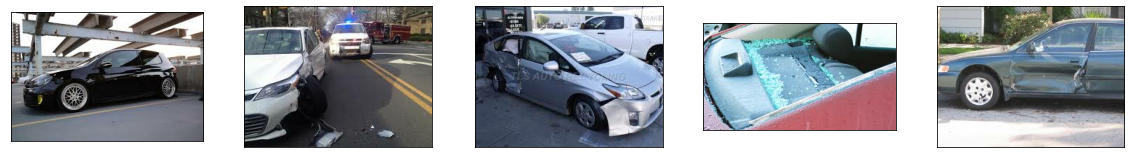

In [6]:
plt.figure(figsize=(20, 15))
for i, (image, label) in enumerate(train.gen_dataset().unbatch().take(5)):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(train.index_to_label[label.numpy()], color='white')
plt.show()

In [7]:
model = image_classifier.create(
    train,
    model_spec='efficientnet_lite0',
    epochs=5,
    use_augmentation=True,
    validation_data=valid
)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________
None
INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


Epoch 1/5
57/57 [==============================] - 63s 1s/step - loss: 0.4925 - accuracy: 0.7966 - val_loss: 0.3536 - val_accuracy: 0.9130
Epoch 2/5
57/57 [==============================] - 63s 1s/step - loss: 0.4092 - accuracy: 0.8734 - val_loss: 0.3388 - val_accuracy: 0.9261
Epoch 3/5
57/57 [==============================] - 63s 1s/step - loss: 0.4011 - accuracy: 0.8723 - val_loss: 0.3290 - val_accuracy: 0.9261
Epoch 4/5
57/57 [==============================] - 61s 1s/step - loss: 0.3958 - accuracy: 0.8761 - val_loss: 0.3303 - val_accuracy: 0.9174
Epoch 5/5
57/57 [==============================] - 64s 1s/step - loss: 0.3869 - accuracy: 0.8843 - val_loss: 0.3252 - val_accuracy: 0.9304


In [8]:
model.export(
    export_dir='.',
    tflite_filename='car_scane.tflite'
)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear
2022-07-08 16:25:50.542888: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpcjhet0dm/assets


INFO:tensorflow:Assets written to: /tmp/tmpcjhet0dm/assets
2022-07-08 16:25:55.993536: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-07-08 16:25:55.993655: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-07-08 16:25:56.057080: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1164] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 913 nodes (656), 923 edges (664), time = 29.901ms.
  function_optimizer: function_optimizer did nothing. time = 0.013ms.

/home/raj/miniconda3/envs/envhackerearth38/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-07-08 16:25:57.018276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357

INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmppt75rwam/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmppt75rwam/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./car_scane.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./car_scane.tflite


In [13]:
MODEL_PATH = 'car_scane.tflite'

In [14]:
def get_interpreter(model_path: str) -> Tuple:
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    return interpreter, input_details, output_details

def predict(image_path: str) -> int:
    interpreter, input_details, output_details = get_interpreter(MODEL_PATH)
    input_shape = input_details[0]['shape']
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.resize(img, (input_shape[2], input_shape[2]))
    img = tf.expand_dims(img, axis=0)
    resized_img = tf.cast(img, dtype=tf.uint8)
    
    interpreter.set_tensor(input_details[0]['index'], resized_img)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    results = np.squeeze(output_data)
    return np.argmax(results, axis=0)

In [16]:
predict('data/training/00-damage/0001.JPEG')

0